# Question 1: Regression Analysis (without GeoSpatial Data)
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

This notebook explores the same question and target variable as the "Q1_Regression" notebook, but without geospatial data. 

**Question 1:** Can we predict real estate purchase price based on climate indicators?
*Target Variable:* Purchase Price ($thou)
*Task:* Run a regression with linear, polynomial features.

## Importing the Necessary Libraries

In [1]:
# common libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# linear regression libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

## Initial Exploration
We will read in the dataset and see if we need do any cleaning before linear regression model.

In [2]:
#read in the dataset
data = pd.read_csv("all_data.csv", index_col=0)
data.head()

,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.93,8.01,15,103.0,173.6,64.7,7.0
1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.81,8.20,30,129.9,166.8,81.1,61.1
2,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.93,8.01,15,103.0,173.6,64.7,7.0
3,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.81,8.20,30,129.9,166.8,81.1,61.1
4,2000-01-31,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,0.93,8.01,15,103.0,173.6,64.7,7.0


In [3]:
#our regression will not need the date and str-type columns; we also need to change the arbitrary "value" column to "avg. temp."
regression = data[data.columns.difference(['Date', 'State', 'StateAbbrv', 'RegionName'])]
regression = regression.rename(columns={'Value': 'Average Temperature'})
regression.head()

,1901-2000 Mean,Anomaly (1901-2000 base period),Bottom-Tier Average Home Value Estimate,Effective Rate (%),Initial Fees and Charges (%),Loan Amount ($thou),Loan-to-Price Ratio (%),Month,Purchase Price ($thou),Share of Total Market (%),Term to Maturity,Top-Tier Average Home Value Estimate,Average Temperature,Year
0,47.8,4.5,122826.545216,8.01,0.93,103.0,64.7,1,173.6,7.0,15,400192.738911,52.3,2000
1,47.8,4.5,122826.545216,8.20,0.81,129.9,81.1,1,166.8,61.1,30,400192.738911,52.3,2000
2,22.5,2.4,71689.188026,8.01,0.93,103.0,64.7,1,173.6,7.0,15,302264.545103,24.9,2000
3,22.5,2.4,71689.188026,8.20,0.81,129.9,81.1,1,166.8,61.1,30,302264.545103,24.9,2000
4,51.8,5.6,61195.175569,8.01,0.93,103.0,64.7,1,173.6,7.0,15,217850.462915,57.4,2000


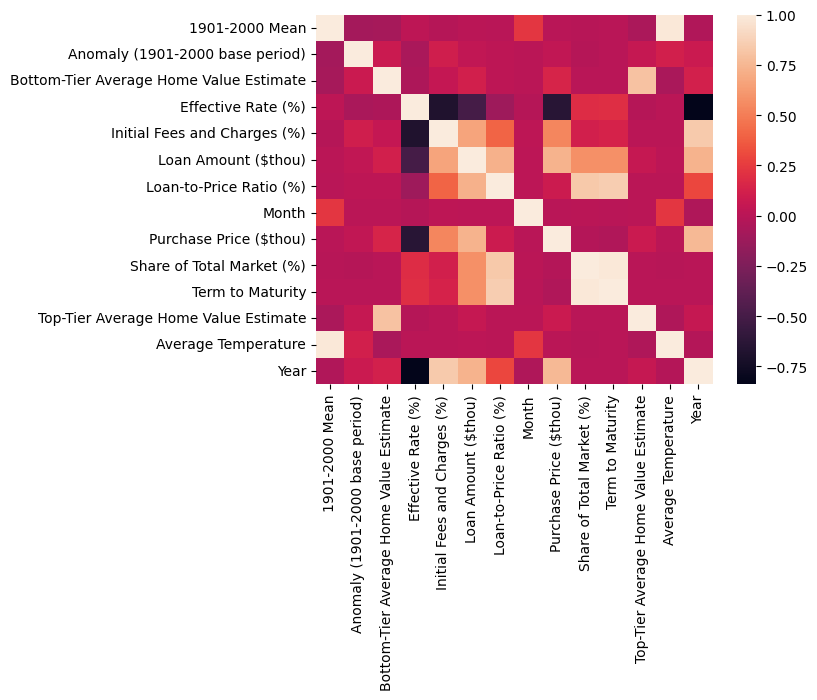

In [4]:
#finding multicolinearity
sns.heatmap(data=regression.corr())
plt.show()

## Split the data
Because this data is origianlly time series, we have broken the year and month into their own columns and dropped the date. Next, we are going to use the latest year as the "test" dataset and all previous years as training.

In [5]:
#sort by year then month
regression.sort_values(by=['Year', 'Month'])

#cut-off for test is 2019
X_train = regression[regression['Year']!=2019][regression.columns.difference(['Purchase Price ($thou)'])]
X_test = regression[regression['Year']==2019][regression.columns.difference(['Purchase Price ($thou)'])]
y_train = regression[regression['Year']!=2019]['Purchase Price ($thou)']
y_test = regression[regression['Year']==2019]['Purchase Price ($thou)']

#see if the data was correctly split
X_test.head()

,1901-2000 Mean,Anomaly (1901-2000 base period),Average Temperature,Bottom-Tier Average Home Value Estimate,Effective Rate (%),Initial Fees and Charges (%),Loan Amount ($thou),Loan-to-Price Ratio (%),Month,Share of Total Market (%),Term to Maturity,Top-Tier Average Home Value Estimate,Year
582366,47.8,2.9,50.7,447669.112417,4.43,1.43,198.7,67.3,1,6.0,15,1.123773e+06,2019
582367,47.8,2.9,50.7,447669.112417,4.90,1.18,250.7,81.2,1,75.1,30,1.123773e+06,2019
582368,22.5,-0.6,21.9,128767.706942,4.43,1.43,198.7,67.3,1,6.0,15,4.188487e+05,2019
582369,22.5,-0.6,21.9,128767.706942,4.90,1.18,250.7,81.2,1,75.1,30,4.188487e+05,2019
582370,51.8,1.5,53.3,131505.853757,4.43,1.43,198.7,67.3,1,6.0,15,3.401442e+05,2019


## Train a Linear Regression Model

In [6]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_test = model_lr.predict(X_test)
y_pred_train = model_lr.predict(X_train)

r_squared_train_linear = r2_score(y_train, y_pred_train)
r_squared_test_linear = r2_score(y_test, y_pred_test)

mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

# Printing results for training
print('r_squared_train:', round(r_squared_train_linear, 3))
print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

# Printing results for testing
print('r_squared_test:',round(r_squared_test_linear, 3))
print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))


r_squared_train: 0.964
mean_squared_error_train: 46.682
r_squared_test: 0.55
mean_squared_error_test: 44.5


In [8]:
coefficients_lr = pd.DataFrame(data = list(zip(X_train.columns, model_lr.coef_)), columns = ['Labels', 'Coefficients'])

coefficients_lr

,Labels,Coefficients
0,1901-2000 Mean,1.899406e+00
1,Anomaly (1901-2000 base period),1.986707e+00
2,Average Temperature,-1.916055e+00
3,Bottom-Tier Average Home Value Estimate,2.228652e-06
4,Effective Rate (%),-1.836476e+00
5,Initial Fees and Charges (%),-1.205665e+01
6,Loan Amount ($thou),1.562009e+00
7,Loan-to-Price Ratio (%),-2.945961e+00
8,Month,-1.311369e-01
9,Share of Total Market (%),-3.527731e-01


## Polynomial Features
First, I am resetting the test and train datasets back to have the most informatio possible.

In [22]:
for x in range(1,5):
    X_poly = PolynomialFeatures(degree=x)
    X_polynomial_train = X_poly.fit_transform(X_train)
    X_polynomial_test = X_poly.fit_transform(X_test)
    model_poly = LinearRegression()
    model_poly.fit(X_polynomial_train, y_train)

    y_pred_poly_test = model_poly.predict(X_polynomial_test)
    y_pred_poly_train = model_poly.predict(X_polynomial_train)
    r_squared_train_poly = model_poly.score(X_polynomial_train, y_train)
    r_squared_test_poly = model_poly.score(X_polynomial_test, y_test)

    mean_squared_error_train_poly = mean_squared_error(y_train, y_pred_poly_train)
    mean_squared_error_test_poly = mean_squared_error(y_test, y_pred_poly_test)

    # Printing results for training
    print('----------------------------')
    print("Degree: ", x)
    print('r_squared_train:', r_squared_train_poly)
    print('mean_squared_error_train:', mean_squared_error_train_poly)

    # Printing results for testing
    print('r_squared_test:',r_squared_test_poly)
    print('mean_squared_error_test:',mean_squared_error_test_poly)
    print('----------------------------')
    print("")

----------------------------
Degree:  1
r_squared_train: 0.880653656108282
mean_squared_error_train: 155.81161552031227
r_squared_test: 0.5235051035119602
mean_squared_error_test: 47.13138143853335
----------------------------

----------------------------
Degree:  2
r_squared_train: 0.8606084234782727
mean_squared_error_train: 181.98150039249526
r_squared_test: -1.7449097358783572
mean_squared_error_test: 271.5063450407258
----------------------------

----------------------------
Degree:  3
r_squared_train: 0.9300460579579755
mean_squared_error_train: 91.3277806940721
r_squared_test: 0.7467113279234594
mean_squared_error_test: 25.053458296585703
----------------------------

----------------------------
Degree:  4
r_squared_train: 0.7961870266821898
mean_squared_error_train: 266.0863131715092
r_squared_test: -4.756484942663214
mean_squared_error_test: 569.3892832378818
----------------------------



## Conclusion

Our model performs better without geospatial data.